# CAISO Energy Storage Bid Analysis

<b>Author:</b> Neal Ma

<b>Date created:</b> October 15, 2024

<b>Description:</b> This notebook contains final visualization and statistical analyses for CAISO energy storage bids from July 1, 2023 - October 1, 2024. 

CAISO Energy Storage Daily Reports:

LCG Consulting Day-Ahead CAISO Prices:

LCG Consulting Real-Time CAISO Prices:


## Notebook Setup and Data Preprocessing

In [12]:
# load libraries
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import seaborn as sns
import matplotlib.dates as mdates
import math
from scipy.stats import ks_2samp
import os


# enable tex for graphs
matplotlib.rc("text", usetex=True)
matplotlib.rc("font", family="serif")

In [13]:
# read energy storage data


ES_df = pd.read_parquet("./data/ES_BIDS/CAISO_ES_BIDS.parquet")


# read real-time price data


RT_df = pd.read_csv("./data/CAISO_RTP.csv")


RT_df["Date"] = pd.to_datetime(RT_df["Date"], format="%m/%d/%Y %I:%M:%S %p")


RT_df = RT_df.drop_duplicates(subset=["Date", "hub"])


RT_df = RT_df.pivot(index="Date", columns="hub", values="price")


# read day-ahead price data


# TODO: Do this
# Directory containing the CSV files


dap_csv_dir = "./data/DAP_CSV/"

# List to hold dataframes
dap_dfs = []

# Read each CSV file and append to the list
for file_name in os.listdir(dap_csv_dir):
    if file_name.endswith(".csv"):
        file_path = os.path.join(dap_csv_dir, file_name)
        dap_dfs.append(pd.read_csv(file_path))

# Concatenate all dataframes
combined_dap_df = pd.concat(dap_dfs)

# Write the combined dataframe to a single CSV file
combined_dap_df.to_csv("./data/CAISO_DAP.csv", index=False)

DA_df = pd.read_csv("./data/CAISO_DAP.csv")


DA_df["Date"] = pd.to_datetime(DA_df["Date"], format="%m/%d/%Y %I:%M:%S %p")


DA_df = DA_df.drop_duplicates(subset=["Date", "zone"])


DA_df = DA_df.pivot(index="Date", columns="zone", values="price")

In [14]:
# merge dataframes
full_df = ES_df.join(RT_df, how="outer")
full_df = full_df.join(DA_df, how="outer")

# filter for data between July 1, 2023 and October 1, 2024
full_df = full_df[
    (full_df.index >= pd.Timestamp("July 1, 2023"))
    & (full_df.index <= pd.Timestamp("October 1, 2024"))
]

hubs = ["TH_NP15", "TH_SP15", "TH_ZP26"]
zones = ["PGAE", "SCE", "SDGE", "VEA"]

# track min, max, avg real-time prices for all timestamps
full_df["rt_price_max"] = full_df[hubs].max(axis=1)
full_df["rt_price_min"] = full_df[hubs].min(axis=1)
full_df["rt_price_avg"] = full_df[hubs].mean(axis=1)

# track min, max, avg day-ahead prices for all timestamps
full_df["da_price_max"] = full_df[zones].max(axis=1)
full_df["da_price_min"] = full_df[zones].min(axis=1)
full_df["da_price_avg"] = full_df[zones].mean(axis=1)

In [15]:
# build daily aggregations (mean)
daily_df = full_df.resample("D").mean()

In [16]:
daily_df

,tot_energy_ifm,tot_energy_ruc,tot_energy_rtpd,tot_energy_rtd,tot_charge_ifm,tot_charge_ruc,tot_charge_rtpd,tot_charge_rtd,as_ru_ifm,as_rd_ifm,...,PGAE,SCE,SDGE,VEA,rt_price_max,rt_price_min,rt_price_avg,da_price_max,da_price_min,da_price_avg
2023-07-01,-28.083333,-28.250000,-92.843750,-70.034722,8131.125000,8131.958333,10043.302083,10105.708333,195.791667,-445.708333,...,45.376249,43.911485,44.715286,42.869567,31.908572,29.989546,31.002598,46.002301,42.716435,44.218147
2023-07-02,-13.750000,-27.375000,101.052083,259.059028,7862.416667,7923.250000,9367.406250,9394.513889,247.666667,-528.500000,...,46.134460,45.024285,45.676905,44.064203,44.908470,37.183060,40.102309,47.052875,43.694483,45.224963
2023-07-03,29.291667,29.291667,-220.677083,-157.256944,8254.125000,8254.166667,9522.177083,9529.645833,239.750000,-408.458333,...,50.364527,50.445677,51.218240,50.020043,37.725160,34.970576,36.163095,52.835693,48.393885,50.512121
2023-07-04,17.208333,17.208333,14.187500,-6.368056,6985.833333,6985.833333,10316.093750,10384.493056,254.166667,-487.958333,...,41.190973,37.044378,37.618260,36.391970,33.854072,20.828158,25.861079,42.042710,36.130532,38.061395
2023-07-05,53.416667,31.041667,215.159574,220.500000,8137.750000,8280.416667,10210.744681,10196.388889,276.333333,-427.416667,...,42.654205,40.559931,41.290909,39.334673,41.335206,37.439950,39.117780,43.519304,39.186816,40.959929
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-09-27,58.166667,58.166667,-177.395833,-64.489583,11085.833333,11085.833333,11407.802083,11416.649306,409.041667,-627.833333,...,40.244835,37.045283,39.503990,35.510959,39.258394,37.310108,38.292945,41.377141,35.510790,38.076267
2024-09-28,22.583333,22.583333,-293.885417,-124.305556,10449.125000,10449.125000,10920.093750,10925.347222,398.833333,-687.666667,...,38.204433,33.017243,33.481658,32.153087,40.528349,32.631059,35.687148,38.233387,32.153087,34.214105
2024-09-29,-5.041667,-5.041667,-128.364583,-166.444444,10764.583333,10764.583333,14802.458333,14923.947917,445.125000,-674.750000,...,36.209160,28.168324,28.769328,27.747835,27.482335,21.765848,23.966624,36.235627,27.527979,30.223662
2024-09-30,58.833333,58.833333,126.656250,68.871528,11379.666667,11379.666667,14909.166667,15019.260417,461.666667,-648.041667,...,46.017710,41.314630,43.864635,39.380768,42.688293,34.898634,38.224384,47.434672,39.380768,42.644436


In [ ]:
def add_prop_columns()

## Price Spike Identification

We define a price spike as anytime where the minimum price in CAISO exceeds two standard deviations above the average mean daily price

In [24]:
def identify_spikes(
    data: pd.DataFrame = None,
    start_date: pd.Timestamp = None,
    end_date: pd.Timestamp = None,
    column: str = "",
    std_threshold: int = 2,
    graph=True,
    description: str = "",
):
    """
    Identifies and returns all timestamps in data where column value exceeds std_threshold above the mean of column value.
    Graphing feature can be activated/deactivated and further tuned using start_date and end_date.
    """
    # copy data
    data_copy = data.copy()
    description = column if description == "" else description

    # determine distribution statistics
    mean = data_copy[column].mean()
    std = data_copy[column].std()
    threshold = mean + std_threshold * std
    # ordinary_band = [mean - std_threshold * std, mean + std_threshold * std]

    # identify timestamps where column value falls outside of ordinary_band
    # abnormal_timestamps = data_copy[
    #     (data[column] < ordinary_band[0]) | (data[column] > ordinary_band[1])
    # ].index
    abnormal_timestamps = data_copy[data[column] > threshold].index

    if graph:
        plt.figure(figsize=(14, 7))
        if start_date:
            data_copy = data_copy[data.index >= start_date]
        if end_date:
            data_copy = data_copy[data.index <= end_date]
        plt.plot(
            data_copy.index,
            data_copy[column],
            color="black",
            label=description,
            linewidth=0.5,
        )
        plt.axhline(
            y=threshold,
            color="r",
            linestyle="--",
            label=r"$\mu +$" + str(std_threshold) + r"$\sigma$",
        )
        # plt.axhline(
        #     y=ordinary_band[1],
        #     color="r",
        #     linestyle="--",
        # )

        filtered_abnormal_timestamps = abnormal_timestamps.copy()
        if start_date:
            filtered_abnormal_timestamps = [
                date for date in filtered_abnormal_timestamps if date >= start_date
            ]
        if end_date:
            filtered_abnormal_timestamps = [
                date for date in filtered_abnormal_timestamps if date <= end_date
            ]

        for idx, timestamp in enumerate(filtered_abnormal_timestamps):
            plt.axvline(
                x=timestamp,
                color="green",
                alpha=0.2,
                label=("Price Spike" if idx == 0 else None),
            )
        plt.legend()
        plt.title(f"Abnormality Detection in {description}")
        plt.xlabel("Date")
        plt.ylabel("Price (\$/MWh)")
        plt.show()

    del data_copy

    return abnormal_timestamps

<>:75: SyntaxWarning: invalid escape sequence '\$'
<>:75: SyntaxWarning: invalid escape sequence '\$'
C:\Users\Astro\AppData\Local\Temp\ipykernel_6104\4122890826.py:75: SyntaxWarning: invalid escape sequence '\$'
  plt.ylabel("Price (\$/MWh)")


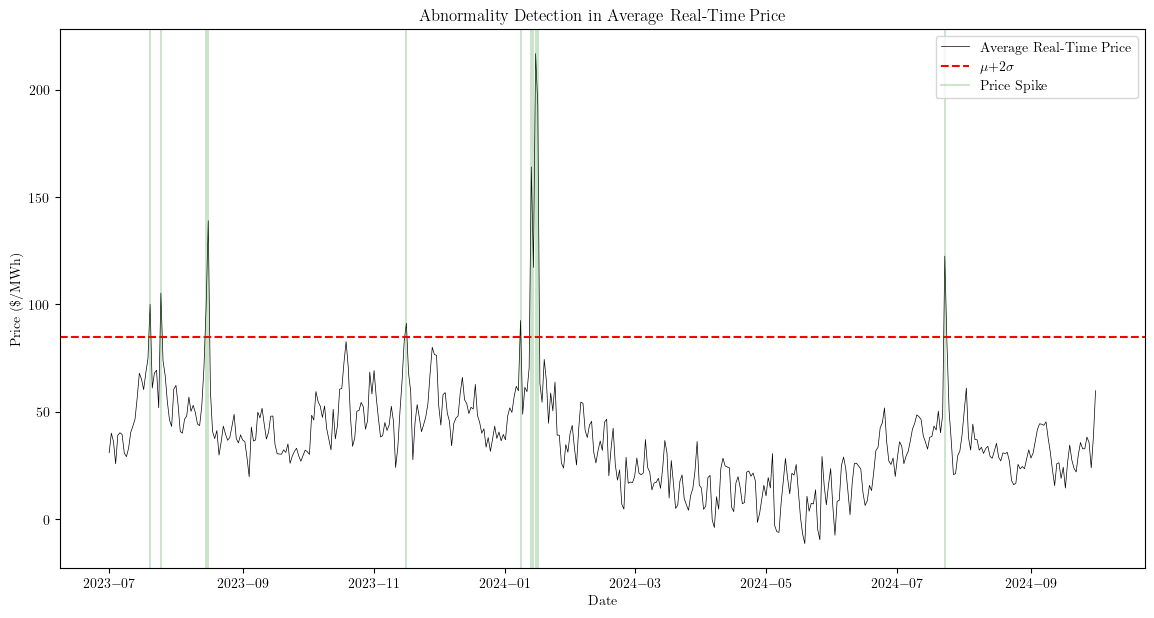

DatetimeIndex(['2023-07-20', '2023-07-25', '2023-08-15', '2023-08-16',
               '2023-11-16', '2024-01-08', '2024-01-13', '2024-01-14',
               '2024-01-15', '2024-01-16', '2024-07-23'],
              dtype='datetime64[ns]', freq=None)


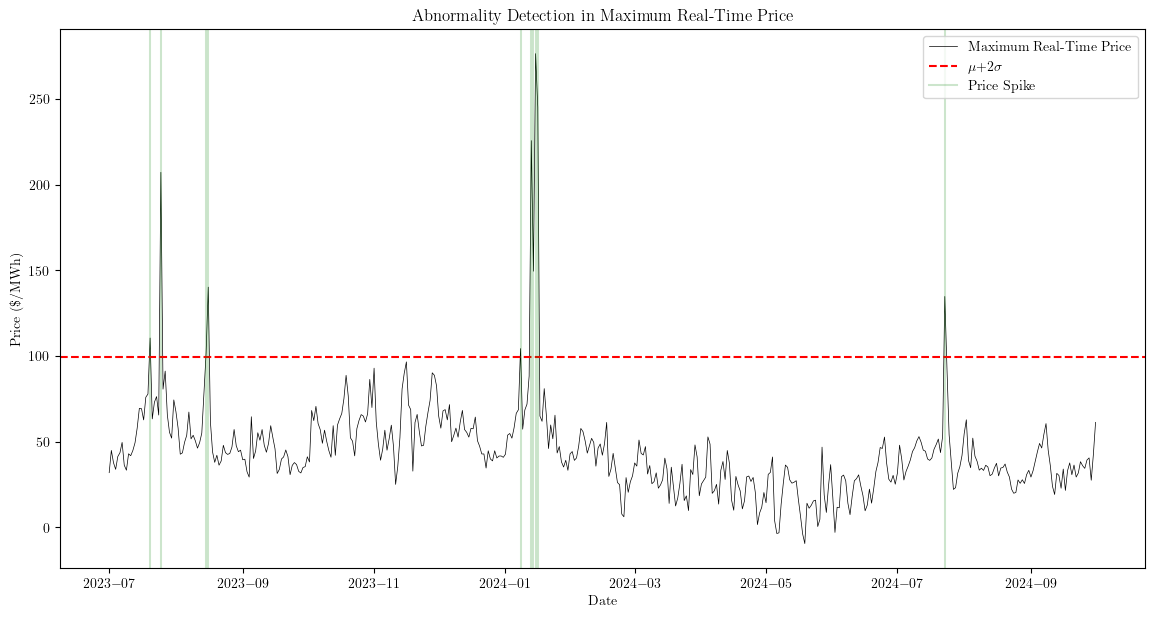

DatetimeIndex(['2023-07-20', '2023-07-25', '2023-08-15', '2023-08-16',
               '2024-01-08', '2024-01-13', '2024-01-14', '2024-01-15',
               '2024-01-16', '2024-07-23'],
              dtype='datetime64[ns]', freq=None)


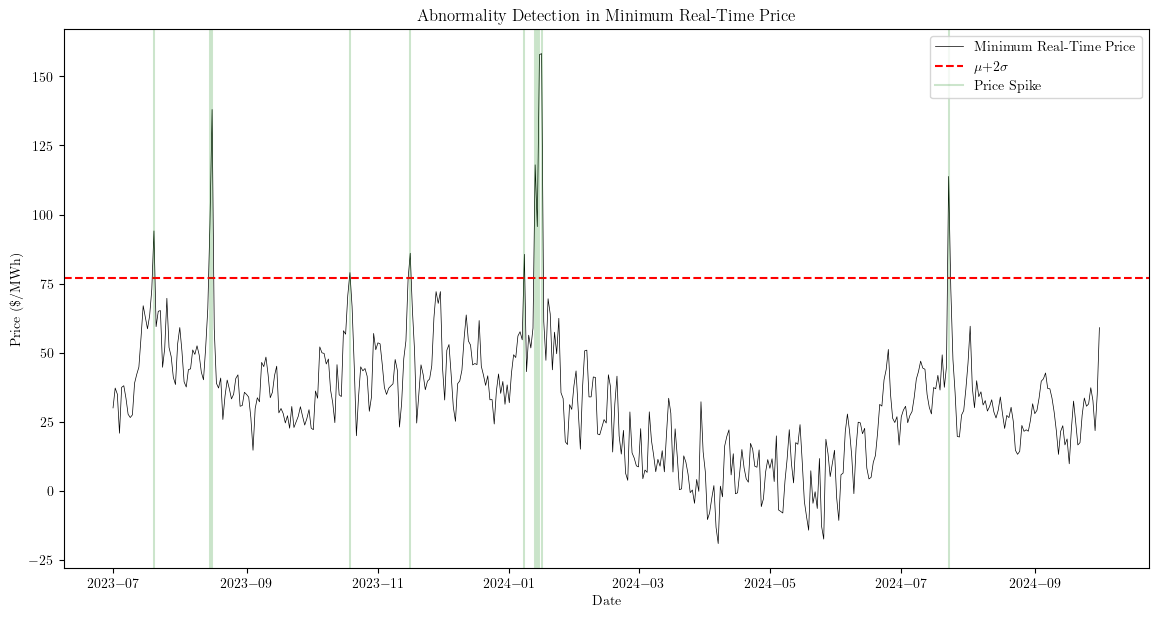

DatetimeIndex(['2023-07-20', '2023-08-15', '2023-08-16', '2023-10-19',
               '2023-11-16', '2024-01-08', '2024-01-13', '2024-01-14',
               '2024-01-15', '2024-01-16', '2024-07-23'],
              dtype='datetime64[ns]', freq=None)


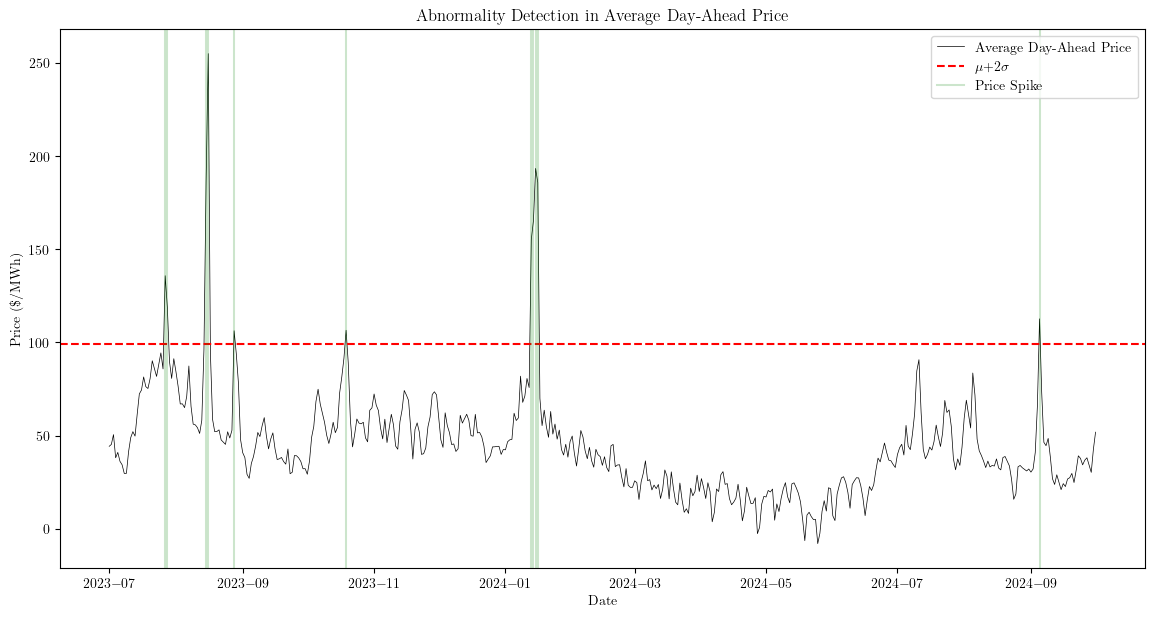

DatetimeIndex(['2023-07-27', '2023-07-28', '2023-08-15', '2023-08-16',
               '2023-08-28', '2023-10-19', '2024-01-13', '2024-01-14',
               '2024-01-15', '2024-01-16', '2024-09-05'],
              dtype='datetime64[ns]', freq=None)


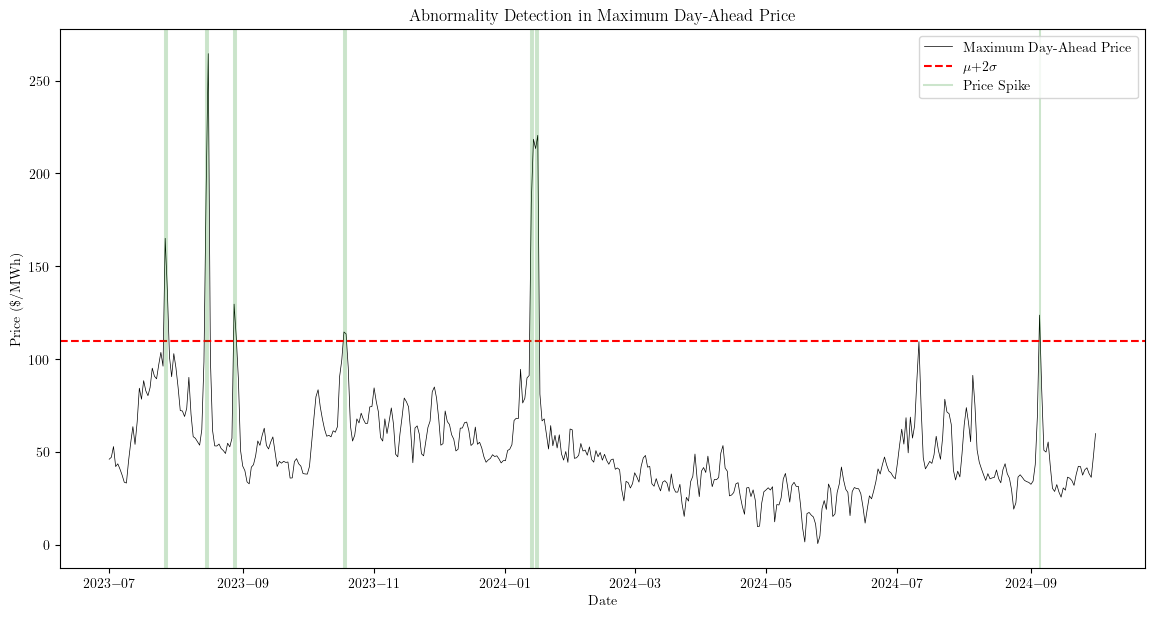

DatetimeIndex(['2023-07-27', '2023-07-28', '2023-08-15', '2023-08-16',
               '2023-08-28', '2023-08-29', '2023-10-18', '2023-10-19',
               '2024-01-13', '2024-01-14', '2024-01-15', '2024-01-16',
               '2024-09-05'],
              dtype='datetime64[ns]', freq=None)


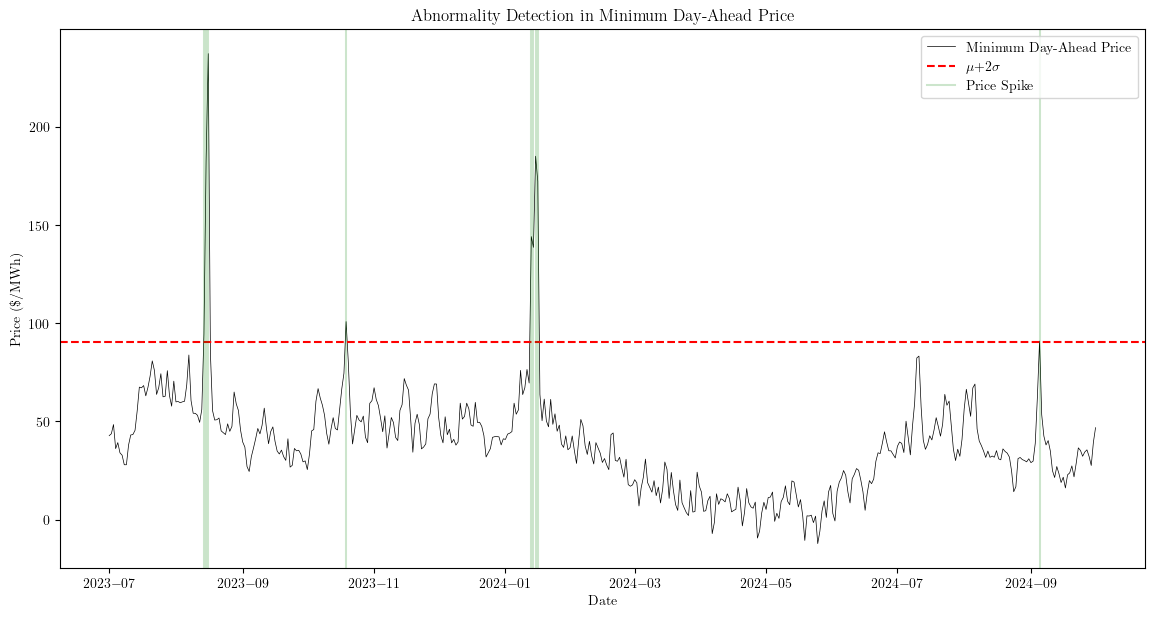

DatetimeIndex(['2023-08-14', '2023-08-15', '2023-08-16', '2023-10-19',
               '2024-01-13', '2024-01-14', '2024-01-15', '2024-01-16',
               '2024-09-05'],
              dtype='datetime64[ns]', freq=None)


In [25]:
price_spike_days_avg = identify_spikes(
    data=daily_df, column="rt_price_avg", description="Average Real-Time Price"
)
print(price_spike_days_avg)

price_spike_days_max = identify_spikes(
    data=daily_df, column="rt_price_max", description="Maximum Real-Time Price"
)
print(price_spike_days_max)

price_spike_days_min = identify_spikes(
    data=daily_df, column="rt_price_min", description="Minimum Real-Time Price"
)
print(price_spike_days_min)

price_spike_days_avg = identify_spikes(
    data=daily_df, column="da_price_avg", description="Average Day-Ahead Price"
)
print(price_spike_days_avg)

price_spike_days_max = identify_spikes(
    data=daily_df, column="da_price_max", description="Maximum Day-Ahead Price"
)
print(price_spike_days_max)

price_spike_days_min = identify_spikes(
    data=daily_df, column="da_price_min", description="Minimum Day-Ahead Price"
)
print(price_spike_days_min)